In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

df = pd.read_parquet('../../time-use-survey-2024/clean/per-tus-2024.parquet')
hdf = pd.read_parquet('../../time-use-survey-2024/clean/hh-tus-2024.parquet')

In [2]:
import yaml

with open('nic-white-collar.yaml', 'r') as fin:
    NIC = yaml.safe_load(fin).keys()

# Salaried people
df = df[df['usual_principal_activity_status'] == 'worked as regular salaried/ wage employee']
# Of the right age
df = df[df['age'] >= 15]
df = df[df['age'] <= 60]
df.dropna(subset=['activity_code'], inplace=True)

# Get time spent
def get_time_spent(time_from, time_to):
    if time_from == time_to:
        return 24 * 60
    start_hour, start_min = map(int, time_from.split(':'))
    end_hour, end_min = map(int, time_to.split(':'))
    minutes = end_hour * 60 + end_min - start_hour * 60 - start_min
    if minutes > 0:
        return minutes
    return 24 * 60 + minutes

df['ts'] = df[['time_from', 'time_to']].apply(lambda x: get_time_spent(**x), axis=1)

# Get personal_info columns
cols = ['sector', 'gender', 'age', 'marital_status', 'education', 'mult', 'nic_2008_principal_activity']
xdf = df.groupby(df.index)[cols].first()

# Summarize time spent on activity categories
df['ACT_CODE'] = df['activity_code'].astype(str).str.get(0).astype(int)
ydf = df.groupby([df.index, 'ACT_CODE'])['ts'].sum().unstack().fillna(value=0)
ydf.columns = ACT_COLS = [f'ACT_{i}' for i in range(1, 10)]

pdf = pd.concat([xdf, ydf], axis=1)
pdf.index = pd.MultiIndex.from_tuples(pdf.index, names=df.index.names)

# Combine this with household info
hh_info = hdf.loc[pdf.index.droplevel(-1).drop_duplicates(),
                  ['religion', 'social_group', 'total_monthly_ce',
                   'energy_cooking', 'energy_lighting', 'washing_type',
                   'sweeping_type', 'dwelling_unit', 'dwelling_unit_structure_type']]
pdf = pdf.reset_index(-1).merge(
    hh_info, how='outer', left_index=True, right_index=True
).reset_index().set_index(pdf.index.names, verify_integrity=True)

pdf['age-group'] = pd.cut(pdf['age'], [10, 20, 30, 40, 50, 60], labels=['<= 20', '20-30', '30-40', '40-50', '50-60'], ordered=True)
pdf['qrt'] = pd.qcut(pdf['total_monthly_ce'], 4, labels=[1, 2, 3, 4])

wc = pdf[pdf['nic_2008_principal_activity'].isin(NIC)]

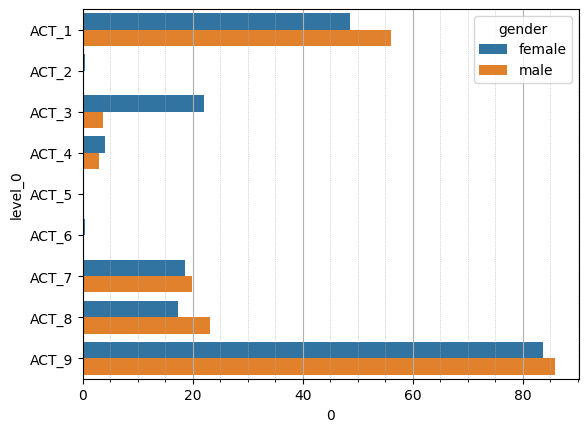

In [3]:
# Time spent by activity group
labels = {
    "ACT_1": "Employment / Paid Work",
    "ACT_2": "Production of Goods for Self-Consumption",
    "ACT_3": "Unpaid Domestic Services for Family",
    "ACT_4": "Unpaid Caregiving for Family",
    "ACT_5": "Unpaid Volunteering / Trainee",
    "ACT_6": "Learning",
    "ACT_7": "Socializing / Religious Practice / Community",
    "ACT_8": "Culture / Leisure / Mass-media / Sports",
    "ACT_9": "Self-Care & Maintenance"
}
ts = wc.groupby('gender').apply(
    lambda x: pd.Series((x[ACT_COLS].values * x['mult'].values.reshape(-1, 1)).sum(axis=0) / x['mult'].sum(), index=ACT_COLS)
)
ts = (ts * 7 / 60).unstack().reset_index()
ts = ts[ts['gender'] != 'transgender']
ax = sns.barplot(ts, x=0, y='level_0', hue='gender')
ax.xaxis.grid()
ax.xaxis.minorticks_on()
ax.xaxis.grid(which='minor', linestyle=':', linewidth=0.5)

In [4]:
ts.columns = ['act', 'gender', 'time_spent']

In [5]:
ts['act'] = ts['act'].replace(labels)

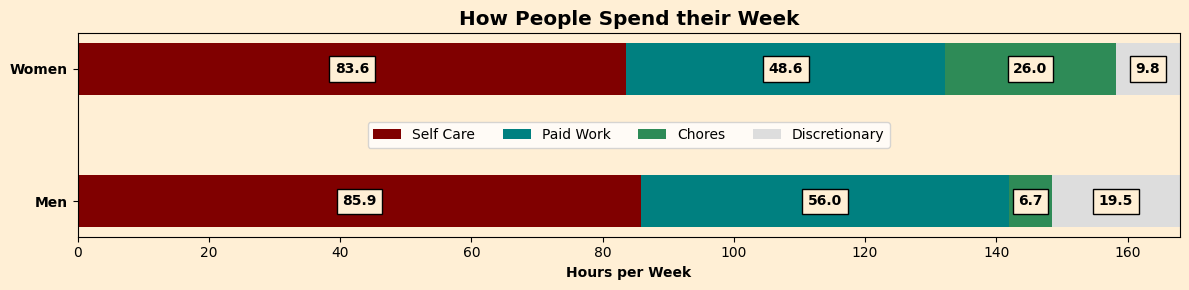

In [22]:
# import matplotlib.pyplot as plt

# Define activity groups
self_care = ["Self-Care & Maintenance"]
paid_work = ["Employment / Paid Work"]
chores = [
    "Unpaid Domestic Services for Family",
    "Unpaid Caregiving for Family"
]

def compute_groups(ts, gender):
    df = ts[ts['gender'] == gender]
    total = df.groupby("act")["time_spent"].sum()
    self_care_time = total[self_care].sum()
    paid_work_time = total[paid_work].sum()
    chores_time = total[chores].sum()
    discretionary_time = 168 - (self_care_time + paid_work_time + chores_time)
    return [self_care_time, paid_work_time, chores_time, discretionary_time]

female_times = compute_groups(ts, "female")
male_times = compute_groups(ts, "male")

# Plot
# with plt.xkcd():
fig, ax = plt.subplots(figsize=(12, 3))
fig.patch.set_facecolor("papayawhip")
ax.set_facecolor("papayawhip")

labels = ['Self Care', 'Paid Work', 'Chores', 'Discretionary']
bar_height = 0.4
y_pos = [1, 0]  # Women on top

ax.barh(1, sum(female_times), color='lightgray', height=bar_height)
ax.barh(0, sum(male_times), color='lightgray', height=bar_height)

left_f, left_m = 0, 0
colors = ['maroon', 'teal', 'seagreen', '#dddddd']

for i, (f, m) in enumerate(zip(female_times, male_times)):
    # Women
    ax.barh(1, f, left=left_f, label=labels[i], color=colors[i], height=bar_height)
    ax.text(left_f + f / 2, 1, f"{f:.1f}", va='center', ha='center', fontsize=10, color='black', bbox=dict(facecolor='papayawhip', ec=None), fontweight='bold')

    # Men
    ax.barh(0, m, left=left_m, color=colors[i], height=bar_height)
    ax.text(left_m + m / 2, 0, f"{m:.1f}", va='center', ha='center', fontsize=10, color='black', bbox=dict(facecolor="papayawhip", ec=None), fontweight='bold')

    left_f += f
    left_m += m


ax.set_yticks(y_pos)
ax.set_yticklabels(['Women', 'Men'], fontweight="bold")# , fontfamily="Comic Sans MS")
ax.set_xlim(0, 168)
ax.set_xlabel("Hours per Week", fontweight="bold")# , fontfamily="Comic Sans MS")
ax.set_title("How People Spend their Week", fontsize="x-large", fontweight="bold")#, fontfamily="Comic Sans MS")

ax.legend(loc='center', ncol=4)# , prop=dict(family="Comic Sans MS"))


plt.tight_layout()


In [9]:
# Meals and genders

In [23]:
xdf = df.loc[wc.index]
TIME = xdf.groupby([xdf.index, 'activity_code'])['ts'].sum().unstack().fillna(value=0) * 7 / 60
meals = TIME[[c for c in TIME if str(c).startswith('31')]]

In [24]:
wc = pd.concat([wc, meals], axis=1)

Text(0.5, 1.05, 'The Great Indian Kitchen')

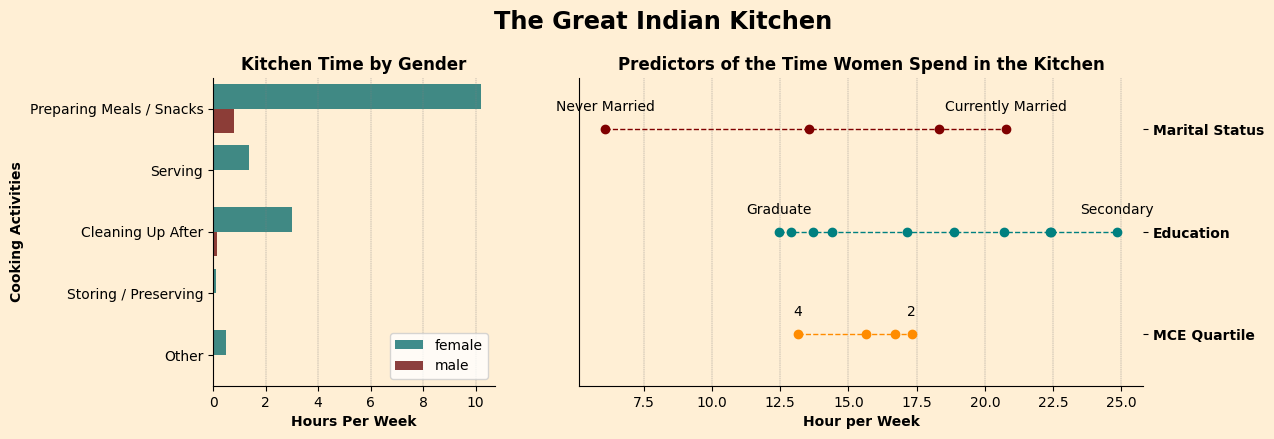

In [40]:
mealtime = wc.groupby('gender').apply(lambda x: (x[meals.columns] * x['mult'].values.reshape(-1, 1)).sum(axis=0) / x['mult'].sum())
mealtime = mealtime.drop(['transgender'], axis=0)
mealtime.columns = ['Preparing Meals / Snacks', 'Serving', 'Cleaning Up After', 'Storing / Preserving', 'Other']
mealtime = mealtime.stack().reset_index()
mealtime.columns = ['gender', 'activity', 'time']

women = wc[wc['gender'] == 'female']
ms = women.groupby('marital_status').apply(lambda x: (x[meals.columns].sum(axis=1) * x['mult']).sum() / x['mult'].sum()).sort_values()
ed = women.groupby('education').apply(lambda x: (x[meals.columns].sum(axis=1) * x['mult']).sum() / x['mult'].sum()).sort_values()
qrt = women.groupby('qrt').apply(lambda x: (x[meals.columns].sum(axis=1) * x['mult']).sum() / x['mult'].sum()).sort_values()
series_list = [ms, ed, qrt]
labels = ['Marital Status', 'Education', 'MCE Quartile']
colors = ['maroon', 'teal', 'darkorange']



# with plt.xkcd():
fig, (axbar, axrange) = plt.subplots(facecolor='papayawhip', ncols=2, width_ratios=[1, 2], figsize=(12, 4))
sns.barplot(mealtime, x="time", y="activity", hue="gender", palette=['teal', 'maroon'], ax=axbar, alpha=0.8)
axbar.grid(True, axis='x', color='gray', linewidth=0.3, linestyle='dashed')
axbar.set_xlabel('Hours Per Week', fontweight="bold")
axbar.set_ylabel('Cooking Activities', fontweight="bold")
axbar.set_facecolor('papayawhip')
axbar.spines[['top', 'right']].set_visible(False)
axbar.legend()
axbar.set_title('Kitchen Time by Gender', fontweight="bold")


fig.patch.set_facecolor("papayawhip")
axrange.set_facecolor("papayawhip")

y_positions = [2, 1, 0]  # One line per series

for series, label, color, y in zip(series_list, labels, colors, y_positions):
    min_val = series.min()
    max_val = series.max()

    # Draw the horizontal range line
    axrange.hlines(y, xmin=min_val, xmax=max_val, color=color, lw=1, linestyle="dashed")

    # Mark and annotate each point
    for i, (idx, val) in enumerate(series.items()):
        axrange.plot(val, y, 'o', color=color)
        if (i == 0 or i == len(series) - 1):
            axrange.text(val, y + 0.15, f"{idx}".title(), ha='center', va='bottom', fontsize=10) #, fontfamily="Comic Sans MS")
axrange.set_ylim(-0.5, 2.5)

axrange.yaxis.tick_right()
axrange.set_yticks(y_positions)
axrange.set_yticklabels(labels, fontweight="bold")
axrange.set_xlabel("Hour per Week", fontweight="bold")
axrange.set_title("Predictors of the Time Women Spend in the Kitchen", fontweight="bold") #, fontfamily="Comic Sans MS")

axrange.spines['top'].set_visible(False)
axrange.spines['right'].set_visible(False)
axrange.grid(True, axis='x', color='gray', linewidth=0.3, linestyle="dashed")

plt.suptitle('The Great Indian Kitchen', y=1.05, fontsize="xx-large", fontweight="bold")

In [47]:
# Socializing and Leisure
codes = {
    911: "Sleep",
    711: "Talking & Chatting",
    842: "Watching TV",
    921: "Eating",
    931: "Personal Care & Hygiene",
    850: "Resting & Relaxing"
}

social = TIME[codes.keys()].copy()
social[['gender', 'mult']] = wc.loc[social.index, ['gender', 'mult']]
socialtime = social.groupby('gender').apply(lambda x: pd.Series((x[codes.keys()].values * x['mult'].values.reshape(-1, 1)).sum(axis=0) / x['mult'].sum(), index=codes.keys()))
socialtime.drop(['transgender'], axis=0, inplace=True)
st = socialtime.unstack().reset_index()
st['act'] = st['level_0'].astype(int).astype(str)

/tmp/ipykernel_41335/2879877285.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(codes.values(), fontweight='bold')


Text(0.5, 0, 'Hours Per Week')

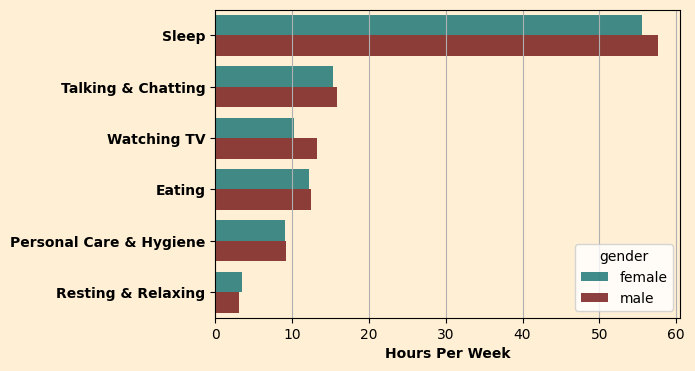

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_facecolor('papayawhip')
fig.set_facecolor('papayawhip')
ax = sns.barplot(st, x=0, y="act", hue="gender", palette=['teal', 'maroon'], alpha=0.8)
ax.set_yticklabels(codes.values(), fontweight='bold')
ax.xaxis.grid()
ax.set_ylabel('')
ax.set_xlabel('Hours Per Week', fontweight='bold')